<a href="https://colab.research.google.com/github/XiaoweiZhang-0/IEEE-AI-ML/blob/master/Deep_Q_Example_Code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import gym
import numpy as np
import tensorflow as tf
import keras
from keras.models import Sequential
from keras.layers import Dense, Input
import matplotlib.pylab as plt
import random
import math

tf.compat.v1.disable_eager_execution()

MAX_EPSILON = 1
MIN_EPSILON = 0.01
LAMBDA = 0.0001
GAMMA = 0.99
BATCH_SIZE = 50
num_episodes = 500

print("finished imports")

finished imports


In [2]:
class Model:
    def __init__(self, num_states, num_actions, batch_size):
        self._num_states = num_states
        self._num_actions = num_actions
        self._batch_size = batch_size
        # define the placeholders
        self._states = None
        self._actions = None
        # the output operations
        self._logits = None
        self._optimizer = None
        self._var_init = None
        # now setup the model
        self.model = None
        self._define_model()
        
    def _define_model(self):
        #self._states = np.empty(shape=[:, self._num_states], dtype=tf.float32)
        #self._q_s_a = np.empty(shape=[:, self._num_actions], dtype=tf.float32)
        # create a couple of fully connected hidden layers
        self.model = Sequential()
        self.model.add(Input(shape=(self._num_states,)))
        self.model.add(Dense(50, activation='relu'))
        self.model.add(Dense(50, activation='relu'))
        self.model.add(Dense(self._num_actions, activation=None))
        self.model.compile(optimizer="Adam", loss="MSE")
        
    def predict_one(self, state):
        return self.model.predict(state.reshape(1, len(state)), verbose=False)

    def predict_batch(self, states):
        #print(states.shape)
        return self.model.predict_on_batch(states)

    def train_batch(self, x_batch, y_batch):
        self.model.fit(x_batch, y_batch,  verbose=False)

    @property
    def num_states(self):
        return self._num_states

    @property
    def num_actions(self):
        return self._num_actions

    @property
    def batch_size(self):
        return self._batch_size

    @property
    def var_init(self):
        return self._var_init

In [3]:
class Memory:
    def __init__(self, max_memory):
        self._max_memory = max_memory
        self._samples = []

    def add_sample(self, sample):
        self._samples.append(sample)
        if len(self._samples) > self._max_memory:
            self._samples.pop(0)

    def sample(self, no_samples):
        if no_samples > len(self._samples):
            return random.sample(self._samples, len(self._samples))
        else:
            return random.sample(self._samples, no_samples)

In [4]:
class GameRunner:
    def __init__(self, model, env, memory, max_eps, min_eps,
                 decay):
        self._env = env
        self._model = model
        self._memory = memory
        self._max_eps = max_eps
        self._min_eps = min_eps
        self._decay = decay
        self._eps = self._max_eps
        self._steps = 0
        self._reward_store = []
        self._max_x_store = []

    def run(self):
        state = self._env.reset()
        tot_reward = 0
        max_x = -100
        while True:
            action = self._choose_action(state)
            next_state, reward, done, info = self._env.step(action)
            if next_state[0] >= 0.5:
                reward += 100
            elif next_state[0] >= 0.25:
                reward += 20
            elif next_state[0] >= 0.1:
                reward += 10

            if next_state[0] > max_x:
                max_x = next_state[0]
            # is the game complete? If so, set the next state to
            # None for storage sake
            if done:
                next_state = None

            self._memory.add_sample((state, action, reward, next_state))
            self._replay()

            # exponentially decay the eps value
            self._steps += 1
            self._eps = MIN_EPSILON + (MAX_EPSILON - MIN_EPSILON) \
                                      * math.exp(-LAMBDA * self._steps)

            # move the agent to the next state and accumulate the reward
            state = next_state
            tot_reward += reward

            # if the game is done, break the loop
            if done:
                self._reward_store.append(tot_reward)
                self._max_x_store.append(max_x)
                break

        print("Step {}, Total reward: {}, Eps: {}".format(self._steps, tot_reward, self._eps))

    def _choose_action(self, state):
        if random.random() < self._eps:
            return random.randint(0, self._model.num_actions - 1)
        else:
            return np.argmax(self._model.predict_one(state))

    def _replay(self):
        batch = self._memory.sample(self._model.batch_size)
        states = np.array([val[0] for val in batch])
        next_states = np.array([(np.zeros(self._model.num_states)
                                 if val[3] is None else val[3]) for val in batch])
        # predict Q(s,a) given the batch of states
        q_s_a = self._model.predict_batch(states)
        # predict Q(s',a') - so that we can do gamma * max(Q(s'a')) below
        q_s_a_d = self._model.predict_batch(next_states)
        # setup training arrays
        x = np.zeros((len(batch), self._model.num_states))
        y = np.zeros((len(batch), self._model.num_actions))
        for i, b in enumerate(batch):
            state, action, reward, next_state = b[0], b[1], b[2], b[3]
            # get the current q values for all actions in state
            current_q = q_s_a[i]
            # update the q value for action
            if next_state is None:
                # in this case, the game completed after action, so there is no max Q(s',a')
                # prediction possible
                current_q[action] = reward
            else:
                current_q[action] = reward + GAMMA * np.amax(q_s_a_d[i])
            x[i] = state
            y[i] = current_q
        self._model.train_batch(x, y)

    @property
    def reward_store(self):
        return self._reward_store

    @property
    def max_x_store(self):
        return self._max_x_store


Episode 1 of 500


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


Step 200, Total reward: -200.0, Eps: 0.9803966865736877
Step 400, Total reward: -200.0, Eps: 0.9611815447608
Step 600, Total reward: -200.0, Eps: 0.9423468882484062
Step 800, Total reward: -200.0, Eps: 0.9238851829227694
Step 1000, Total reward: -200.0, Eps: 0.9057890438555999
Step 1200, Total reward: -200.0, Eps: 0.888051232349986
Step 1400, Total reward: -200.0, Eps: 0.8706646530448178
Step 1600, Total reward: -200.0, Eps: 0.8536223510765493
Step 1800, Total reward: -200.0, Eps: 0.8369175092971592
Step 2000, Total reward: -200.0, Eps: 0.820543445547202
Episode 11 of 500
Step 2200, Total reward: -200.0, Eps: 0.8044936099828537
Step 2400, Total reward: -200.0, Eps: 0.7887615824558878
Step 2600, Total reward: -200.0, Eps: 0.7733410699455306
Step 2800, Total reward: -200.0, Eps: 0.7582259040411682
Step 3000, Total reward: -200.0, Eps: 0.7434100384749007
Step 3200, Total reward: -200.0, Eps: 0.7288875467029541
Step 3400, Total reward: -200.0, Eps: 0.7146526195349836
Step 3600, Total rewar

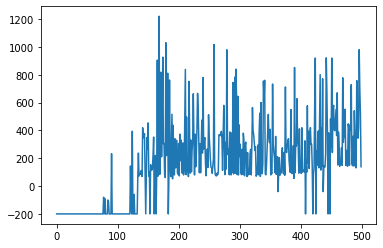

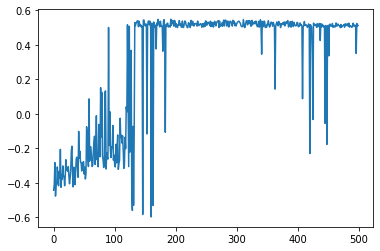

In [5]:
env_name = 'MountainCar-v0'
env = gym.make(env_name)

num_states = env.env.observation_space.shape[0]
num_actions = env.env.action_space.n

model = Model(num_states, num_actions, BATCH_SIZE)
mem = Memory(50000)


gr = GameRunner(model, env, mem, MAX_EPSILON, MIN_EPSILON, LAMBDA)

cnt = 0
while cnt < num_episodes:
    if cnt % 10 == 0:
        print('Episode {} of {}'.format(cnt+1, num_episodes))
    gr.run()
    cnt += 1
plt.plot(gr.reward_store)
plt.show()
plt.close("all")
plt.plot(gr.max_x_store)
plt.show()